## Inferencing [ Unet ]

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model

In [51]:
# colors = {0: 'black', 1: 'white'}
# cmap = plt.cm.colors.ListedColormap([colors[val] for val in range(2)])

def visualize(image,mask,pred):
    plt.figure(figsize=(10, 10))

    title = ['Image', 'True Mask', 'Predicted Mask']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        if i == 0:
            plt.imshow(image)
            plt.axis('off')
        elif i == 1:
            plt.imshow(mask)
            plt.axis('off')
        else:
            # cmap = plt.cm.gray 
            # cmap.set_under('black')
            plt.imshow(pred)
            plt.show()
    plt.show()

In [6]:
image = cv2.imread('test_data/test_image.png')
mask = cv2.imread('test_data/test_mask.png')

In [8]:
image.shape , mask.shape

((256, 256, 3), (256, 256, 3))

In [9]:
x = np.expand_dims(image,axis=0)
x.shape

(1, 256, 256, 3)

In [10]:
x

array([[[[ 90,  35,  50],
         [ 90,  34,  48],
         [ 90,  33,  46],
         ...,
         [106,  51,  65],
         [109,  54,  67],
         [112,  58,  72]],

        [[ 96,  41,  58],
         [ 95,  39,  54],
         [ 94,  37,  51],
         ...,
         [115,  55,  68],
         [115,  56,  69],
         [115,  57,  70]],

        [[103,  48,  68],
         [101,  45,  62],
         [100,  41,  57],
         ...,
         [123,  59,  72],
         [120,  57,  69],
         [115,  53,  66]],

        ...,

        [[124,  66,  95],
         [125,  68,  97],
         [124,  69,  99],
         ...,
         [ 99,  54,  80],
         [ 95,  51,  77],
         [ 89,  45,  71]],

        [[118,  60,  90],
         [120,  65,  94],
         [122,  68,  98],
         ...,
         [ 93,  49,  75],
         [ 90,  47,  72],
         [ 86,  42,  67]],

        [[103,  49,  75],
         [108,  55,  81],
         [112,  60,  87],
         ...,
         [ 87,  43,  68],
        

In [19]:
# to evaluate the overlap between predicted and ground truth segmentation masks.
def dice_coef(y_true, y_pred, smooth=1):   
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou



#to optimize segmentation models for better delineation of objects in medical imagery.
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * dice_loss(tf.cast(y_true, tf.float32), y_pred)

In [11]:
MODEL_PATH = 'saved_models/unet.h5'

In [20]:
model = load_model(MODEL_PATH,custom_objects={'dice_coef':dice_coef,'bce_dice_loss':bce_dice_loss,'iou_coef':iou_coef,'dice_loss':dice_loss},compile=False)

In [21]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',dice_coef,dice_loss,iou_coef,bce_dice_loss])

In [22]:
pred = model.predict(x)

1/1 [==============================] - 3s 3s/step


In [23]:
pred = (pred > 0.5).astype(np.uint8)

In [24]:
pred.shape

(1, 256, 256, 1)

In [25]:
pred = np.squeeze(pred,axis=0)
pred.shape

(256, 256, 1)

In [26]:
pred_binary = (pred * 255).astype(np.uint8)

# Save the binary mask using cv2.imwrite
cv2.imwrite("test_data/pred_mask.png", pred_binary)

True

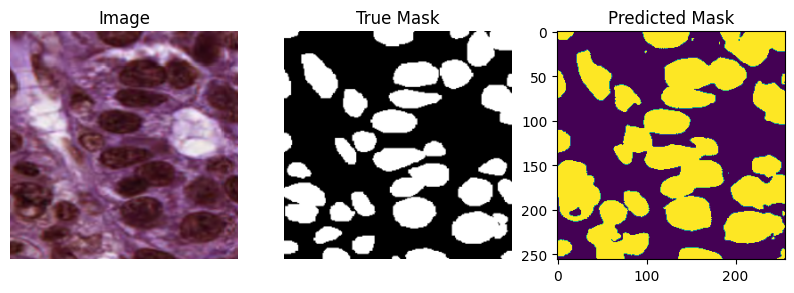

In [53]:
visualize(image,mask,pred)